In [1]:
import matplotlib.pyplot as plt
import numpy as np
#import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.layers import Input, Dense, Flatten, Reshape, Dropout, LeakyReLU, ReLU, LayerNormalization, GaussianNoise
#from tensorflow.keras.layers import BatchNormalization
from tensorflow.compat.v1.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from keras.layers.core import Activation, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose, MaxPooling2D
from keras import initializers
from math import ceil
import time
from tensorflow_addons.layers import SpectralNormalization

In [2]:
#Updated Versions
#Spectral Normalization Model
def build_cifar10_discriminator(image_shape=(32, 32, 3)):
    
    model = Sequential()
    
    #16 output filters, so number of channels jumps from 1 to 16
    #kernel_size = 5 means we use a 5x5 convolution window
    #strides defaults to (1,1) when unspecified, "same" padding means we'll preserve the image size
    model.add(Conv2D(16, kernel_size=5, strides=2, padding="same", input_shape=(32, 32, 3), 
                     activation = 'relu', use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))) #40
    model.add(LeakyReLU(0.2))
    model.add(SpectralNormalization(Conv2D(32, kernel_size=5, strides=2, padding="same", 
                     activation = 'relu', use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))))
    model.add(LeakyReLU(0.2))
    
    #Second layer
    model.add(SpectralNormalization(Conv2D(64, kernel_size=5, strides=2, padding="same", 
                     activation = 'relu', use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))))
    model.add(LeakyReLU(0.2))
    model.add(SpectralNormalization(Conv2D(128, kernel_size=5, strides=2, padding="same", 
                     activation = 'relu', use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))))
    model.add(LeakyReLU(0.2))

    #Flatten for Final Output Layer
    model.add(Flatten())

    #Output layer
    model.add(Dense(1, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(Activation("sigmoid"))
    
    #Final Output
    print("\nDiscriminator")
    model.summary()
    return model




#Spectral Normalization Model
def build_cifar10_generator(z_dim=100):
    
    model = Sequential()
    
    #First Layer (4x4)
    model.add(Dense(4*4*128, input_dim=z_dim, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    model.add(Reshape((4,4,128)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 8x8
    model.add(SpectralNormalization(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', 
                              use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))))
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 16x16
    model.add(SpectralNormalization(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same', 
                              use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02))))
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 32x32
    model.add(Conv2DTranspose(3, kernel_size=5, strides=2, padding='same',
          use_bias=True, kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    
    # output layer
    model.add(Activation('tanh'))

    print("\nGenerator")
    model.summary()
    return model




#Build and Compile Networks
#Variables
#Loss Functions:  Don't seem to matter for performance, any choice will work
#Learning rates:  Trying higher learning rate for Discriminator;  
#Discriminator is easier to succeed, gives generator a better chance at competition, prevents mode collapse
lr_d=2e-4
lr_g=1e-4
z_dim=100
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
image_shape = X_train[0].shape

D = build_cifar10_discriminator(image_shape)
G = build_cifar10_generator(z_dim)

D.compile(Adam(learning_rate=lr_d, beta_1=0.5), loss='binary_crossentropy', metrics=['accuracy'])
D.trainable = False

z = Input(shape=(z_dim, ))
D_of_G = Model(inputs=z, outputs=D(G(z)))
D_of_G.compile(Adam(learning_rate=lr_g, beta_1=0.5), loss='binary_crossentropy', metrics=['binary_accuracy'])


Discriminator
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 16)        1216      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 16)        0         
                                                                 
 spectral_normalization (Spe  (None, 8, 8, 32)         12864     
 ctralNormalization)                                             
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8, 8, 32)          0         
                                                                 
 spectral_normalization_1 (S  (None, 4, 4, 64)         51328     
 pectralNormalization)                                           
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 4, 4,

In [3]:
#Function for plotting images
def plot_images(images, filename):
    h, w, c = images.shape[1:]
    #images = (1/(2*2.25)) * images + 0.5
    images = 0.5 * images + 0.5
    grid_size = ceil(np.sqrt(images.shape[0]))
    images = (images.reshape(grid_size, grid_size, h, w, c)
              .transpose(0, 2, 1, 3, 4)
              .reshape(grid_size*h, grid_size*w, c))
    plt.figure(figsize=(16, 16))
    plt.imsave(filename, images)
    
#Function for Plotting Losses During Training
def plot_losses(losses_d, losses_g, filename):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2))
    axes[0].plot(losses_d)
    axes[1].plot(losses_g)
    axes[0].set_title("losses_d")
    axes[1].set_title("losses_g")
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()
    #plt.close()
    
#Functions for smoothing labels of 1 and 0
# Smoothing class=1 to [0.8, 1.0]
def smooth_positive_labels(y):
    return y - 0.2 + (np.random.random(y.shape) * 0.2)

# Smoothing class=0 to [0.0, 0.1]
def smooth_negative_labels(y):
    return y + (np.random.random(y.shape) * 0.1)

#Function for generating latent points to feed into generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
     x_input = np.random.randn(latent_dim * n_samples)
     # reshape into a batch of inputs for the network
     x_input = x_input.reshape((n_samples, latent_dim))
     return x_input
    

#Function for adding noise to images
#  Adding noise to images prevents discriminator overfitting, inhibits performance to allow
#   for better rivalry with the generator (which is generally slower to train)
#This function adds 'salt and pepper noise' (randomly set pixels to either -1 or 1) 
# def noisy(image):
#     row,col,ch = image.shape
#     s_vs_p = 0.5
#     amount = 0.004
#     out = np.copy(image)
#     # Salt mode
#     num_salt = np.ceil(amount * image.size * s_vs_p)
#     coords = tuple([np.random.randint(0, i - 1, int(num_salt))
#             for i in image.shape])
#     out[coords] = 1

#     # Pepper mode
#     num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
#     coords = tuple([np.random.randint(0, i - 1, int(num_pepper))
#             for i in image.shape])
#     out[coords] = -1
#     return out

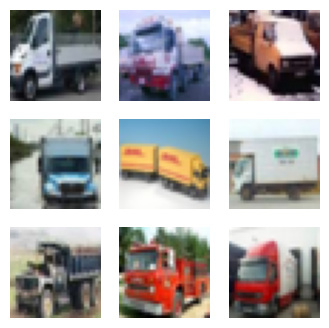

In [4]:
# #Test only grabbing images of one type

#Load the CIFAR10 data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
#Concatenate X_train and X_test for more data
X_train = np.concatenate((X_train,X_test))
y_train = np.concatenate((y_train,y_test))
#Only use index 0, AKA Airplanes
index = np.where(y_train.reshape(-1) == 9)
X_train = X_train[index]
y_train = y_train[index]

#Testing to make sure it's just airplanes
fig,axs = plt.subplots(3,3,figsize=(4,4),sharey=True,sharex=True)
cnt=0
for i in range(3):
    for j in range(3):
        axs[i, j].imshow(X_train[-9:][cnt,:,:])
        axs[i, j].axis('off')
        cnt+=1

image shape (32, 32, 3), min val -0.9607843160629272, max val 0.9921568632125854
Epoch 0
Time for epoch:  26.83344602584839
loss_d=0.33041, loss_g=1.72647
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

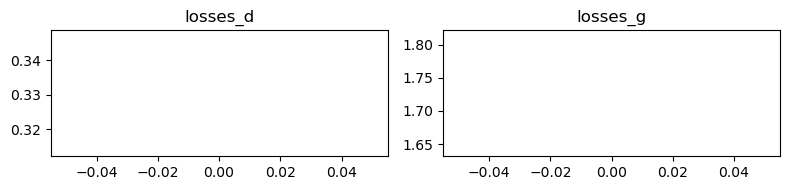

Epoch 1
Time for epoch:  26.483235120773315
Epoch 2
Time for epoch:  24.149962663650513
Epoch 3
Time for epoch:  24.281296730041504
Epoch 4
Time for epoch:  23.357340335845947
Epoch 5
Time for epoch:  24.733956575393677
loss_d=0.49553, loss_g=1.52065
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


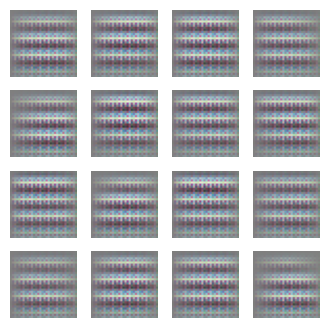

<Figure size 1600x1600 with 0 Axes>

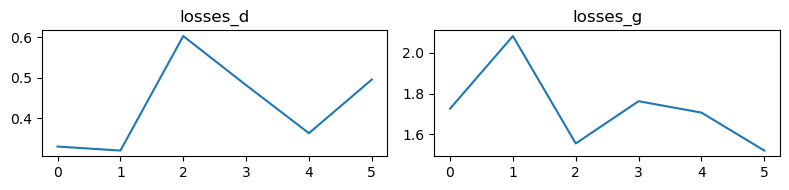

Epoch 6
Time for epoch:  23.77877449989319
Epoch 7
Time for epoch:  23.071970224380493
Epoch 8
Time for epoch:  23.4980251789093
Epoch 9
Time for epoch:  26.368113040924072
Epoch 10
Time for epoch:  25.774040460586548
loss_d=0.52696, loss_g=1.29080
2/2 [==============================] - 0s 8ms/step
	Plotting images and losses


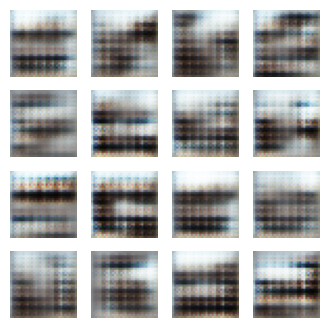

<Figure size 1600x1600 with 0 Axes>

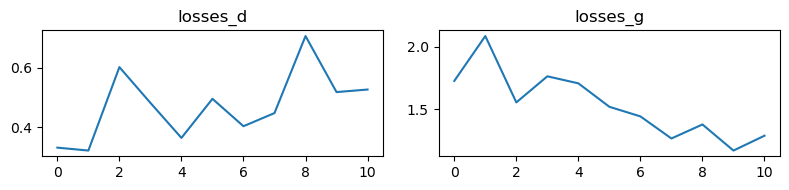

Epoch 11
Time for epoch:  25.515313863754272
Epoch 12
Time for epoch:  24.82514786720276
Epoch 13
Time for epoch:  22.81702160835266
Epoch 14
Time for epoch:  23.221813678741455
Epoch 15
Time for epoch:  23.056966304779053
loss_d=0.52553, loss_g=1.07090
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


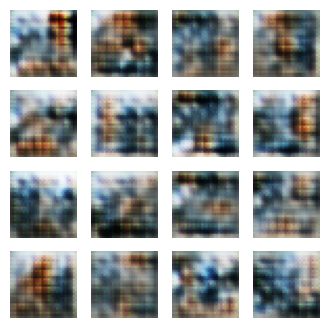

<Figure size 1600x1600 with 0 Axes>

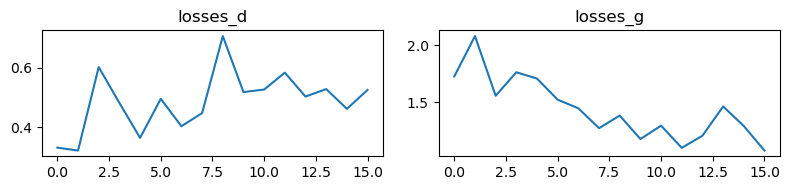

Epoch 16
Time for epoch:  23.828190326690674
Epoch 17
Time for epoch:  22.90001392364502
Epoch 18
Time for epoch:  22.612415075302124
Epoch 19
Time for epoch:  22.54080867767334
Epoch 20
Time for epoch:  22.47298502922058
loss_d=0.57387, loss_g=1.31306
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


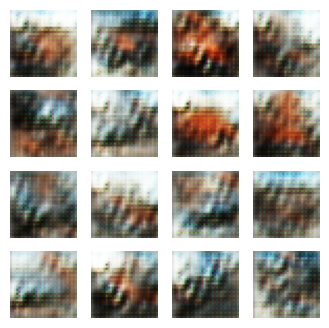

<Figure size 1600x1600 with 0 Axes>

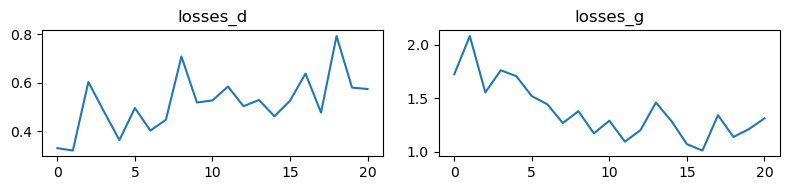

Epoch 21
Time for epoch:  22.63501501083374
Epoch 22
Time for epoch:  22.536357402801514
Epoch 23
Time for epoch:  22.90733242034912
Epoch 24
Time for epoch:  23.355184078216553
Epoch 25
Time for epoch:  23.26331353187561
loss_d=0.66953, loss_g=1.20760
2/2 [==============================] - 0s 6ms/step
	Plotting images and losses


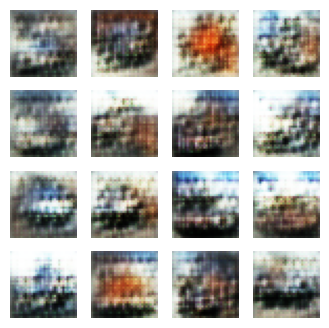

<Figure size 1600x1600 with 0 Axes>

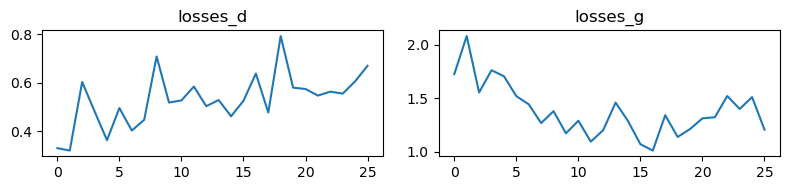

Epoch 26
Time for epoch:  25.384897232055664
Epoch 27
Time for epoch:  26.14400839805603
Epoch 28
Time for epoch:  26.76251745223999
Epoch 29
Time for epoch:  26.168968200683594
Epoch 30
Time for epoch:  23.300972938537598
loss_d=0.66155, loss_g=1.42327
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


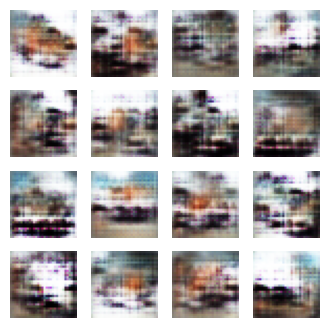

<Figure size 1600x1600 with 0 Axes>

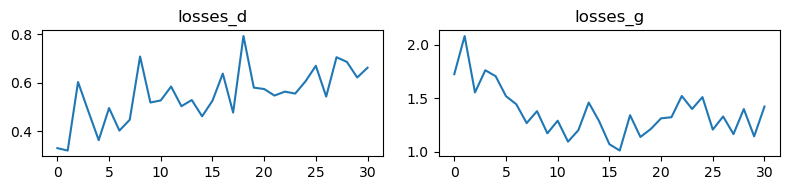

Epoch 31
Time for epoch:  23.456653594970703
Epoch 32
Time for epoch:  27.34456467628479
Epoch 33
Time for epoch:  25.374932765960693
Epoch 34
Time for epoch:  26.717975854873657
Epoch 35
Time for epoch:  25.73236608505249
loss_d=0.56433, loss_g=1.31940
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


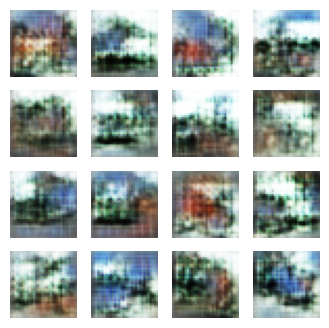

<Figure size 1600x1600 with 0 Axes>

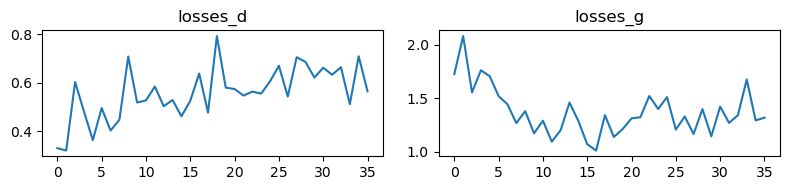

Epoch 36
Time for epoch:  24.334079265594482
Epoch 37
Time for epoch:  23.958319425582886
Epoch 38
Time for epoch:  23.652480602264404
Epoch 39
Time for epoch:  23.08444309234619
Epoch 40
Time for epoch:  22.943729639053345
loss_d=0.54288, loss_g=1.29943
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


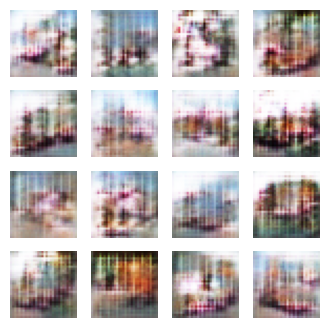

<Figure size 1600x1600 with 0 Axes>

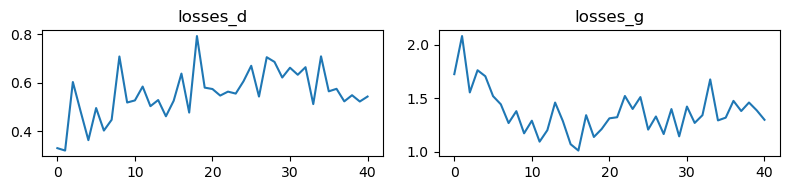

Epoch 41
Time for epoch:  23.305156469345093
Epoch 42
Time for epoch:  22.96466612815857
Epoch 43
Time for epoch:  22.979873180389404
Epoch 44
Time for epoch:  22.93761372566223
Epoch 45
Time for epoch:  22.871776580810547
loss_d=0.49035, loss_g=1.63078
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


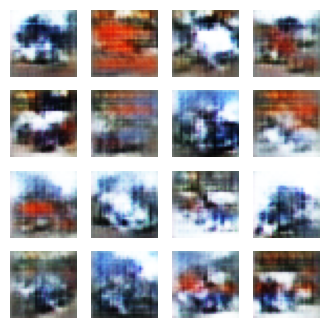

<Figure size 1600x1600 with 0 Axes>

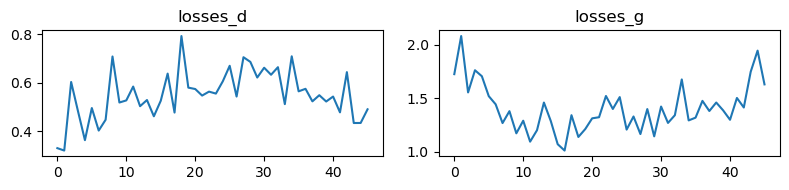

Epoch 46
Time for epoch:  22.911701440811157
Epoch 47
Time for epoch:  23.213945150375366
Epoch 48
Time for epoch:  22.903079748153687
Epoch 49
Time for epoch:  23.804857969284058
Epoch 50
Time for epoch:  25.00498604774475
loss_d=0.54492, loss_g=1.56353
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


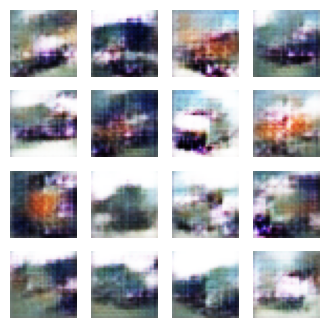

<Figure size 1600x1600 with 0 Axes>

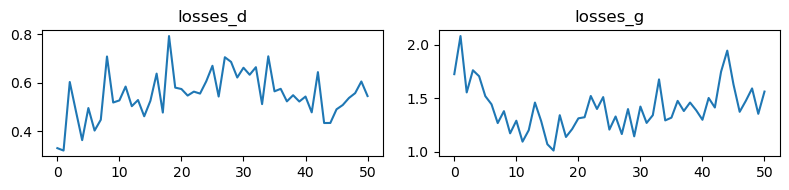

Epoch 51
Time for epoch:  24.515693426132202
Epoch 52
Time for epoch:  24.597168922424316
Epoch 53
Time for epoch:  24.555391550064087
Epoch 54
Time for epoch:  24.667831420898438
Epoch 55
Time for epoch:  24.764930486679077
loss_d=0.49564, loss_g=1.66204
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


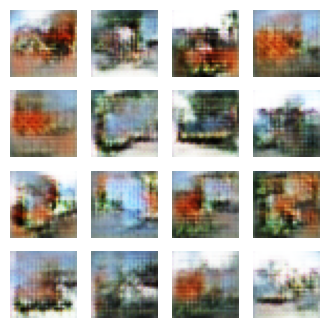

<Figure size 1600x1600 with 0 Axes>

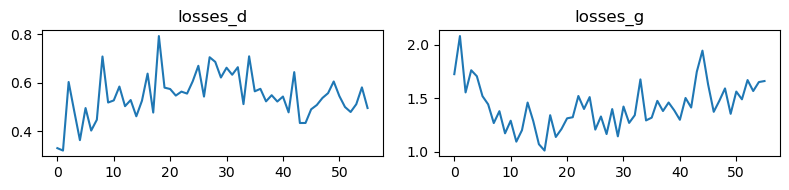

Epoch 56
Time for epoch:  24.511359214782715
Epoch 57
Time for epoch:  24.36665916442871
Epoch 58
Time for epoch:  24.868601083755493
Epoch 59
Time for epoch:  24.541369915008545
Epoch 60
Time for epoch:  24.38058042526245
loss_d=0.47800, loss_g=1.56014
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


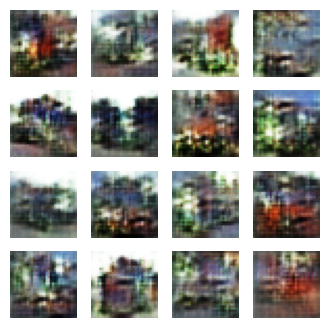

<Figure size 1600x1600 with 0 Axes>

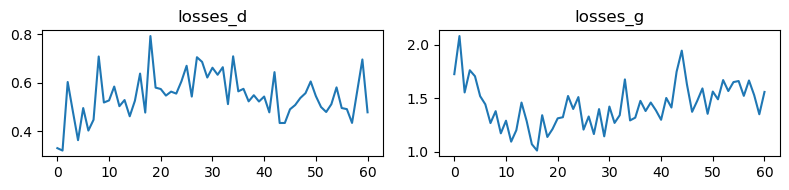

Epoch 61
Time for epoch:  24.695110082626343
Epoch 62
Time for epoch:  25.102815628051758
Epoch 63
Time for epoch:  24.852601051330566
Epoch 64
Time for epoch:  25.591407299041748
Epoch 65
Time for epoch:  24.306308031082153
loss_d=0.57730, loss_g=1.43452
2/2 [==============================] - 0s 6ms/step
	Plotting images and losses


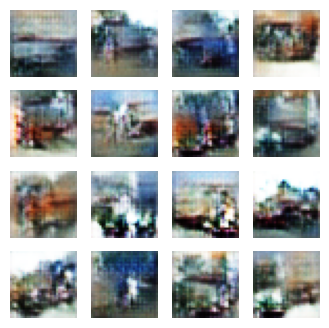

<Figure size 1600x1600 with 0 Axes>

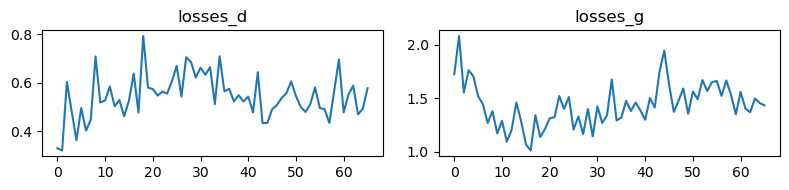

Epoch 66
Time for epoch:  25.228856801986694
Epoch 67
Time for epoch:  23.158704042434692
Epoch 68
Time for epoch:  26.195444583892822
Epoch 69
Time for epoch:  26.87052345275879
Epoch 70
Time for epoch:  27.45122766494751
loss_d=0.63018, loss_g=1.47909
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


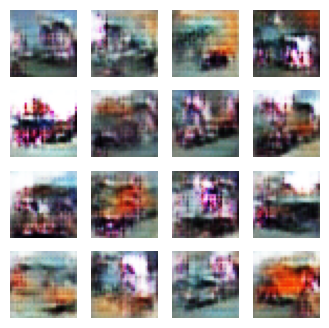

<Figure size 1600x1600 with 0 Axes>

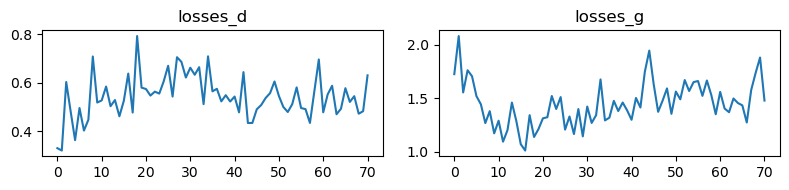

Epoch 71
Time for epoch:  28.644689321517944
Epoch 72
Time for epoch:  36.9220244884491
Epoch 73
Time for epoch:  37.18340349197388
Epoch 74
Time for epoch:  36.26447939872742
Epoch 75
Time for epoch:  37.00723743438721
loss_d=0.53036, loss_g=1.43031
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


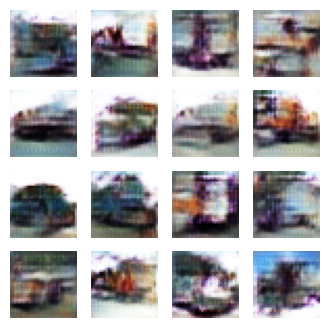

<Figure size 1600x1600 with 0 Axes>

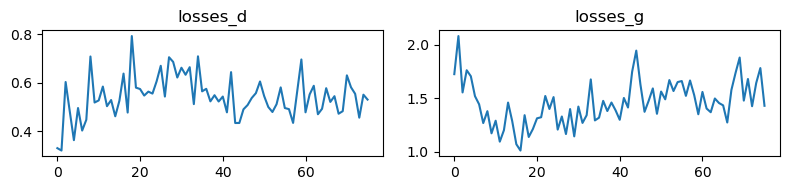

Epoch 76
Time for epoch:  36.617918491363525
Epoch 77
Time for epoch:  36.46904158592224
Epoch 78
Time for epoch:  37.0498366355896
Epoch 79
Time for epoch:  34.97744536399841
Epoch 80
Time for epoch:  36.65020418167114
loss_d=0.47421, loss_g=1.40787
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


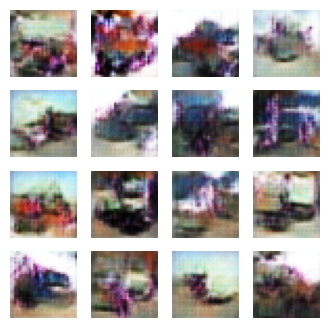

<Figure size 1600x1600 with 0 Axes>

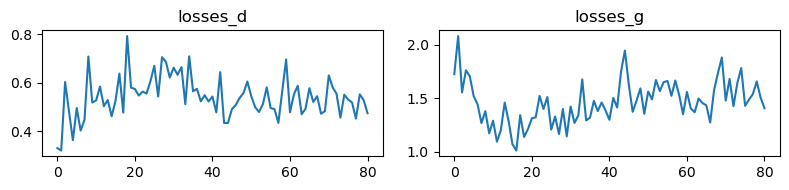

Epoch 81
Time for epoch:  35.90173840522766
Epoch 82
Time for epoch:  37.05233287811279
Epoch 83
Time for epoch:  34.81392526626587
Epoch 84
Time for epoch:  37.4240882396698
Epoch 85
Time for epoch:  37.268908977508545
loss_d=0.60450, loss_g=1.55511
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


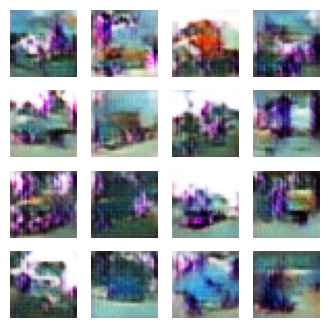

<Figure size 1600x1600 with 0 Axes>

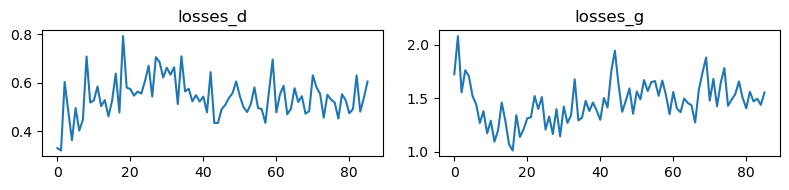

Epoch 86
Time for epoch:  37.75262117385864
Epoch 87
Time for epoch:  34.91891288757324
Epoch 88
Time for epoch:  36.57200241088867
Epoch 89
Time for epoch:  36.429508686065674
Epoch 90
Time for epoch:  37.19442629814148
loss_d=0.50234, loss_g=1.36099
2/2 [==============================] - 0s 9ms/step
	Plotting images and losses


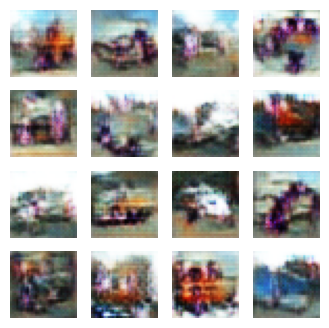

<Figure size 1600x1600 with 0 Axes>

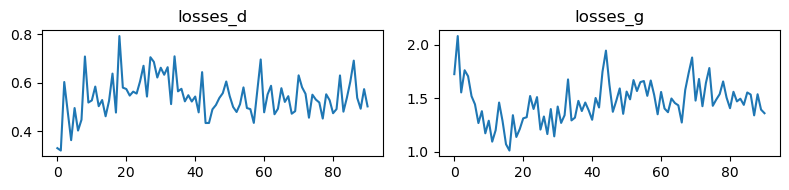

Epoch 91
Time for epoch:  35.346864461898804
Epoch 92
Time for epoch:  36.22217297554016
Epoch 93
Time for epoch:  37.15710639953613
Epoch 94
Time for epoch:  37.090564489364624
Epoch 95
Time for epoch:  37.09670400619507
loss_d=0.59055, loss_g=1.49149
2/2 [==============================] - 0s 9ms/step
	Plotting images and losses


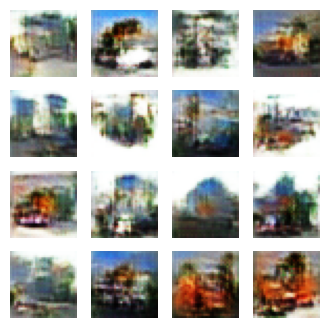

<Figure size 1600x1600 with 0 Axes>

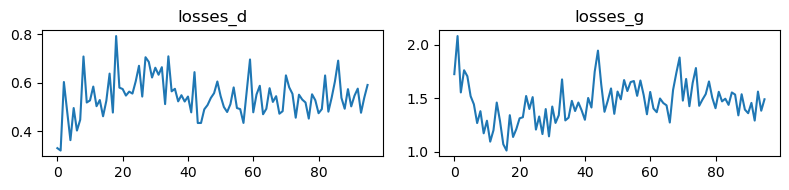

Epoch 96
Time for epoch:  36.22423720359802
Epoch 97
Time for epoch:  36.990678787231445
Epoch 98
Time for epoch:  35.12391710281372
Epoch 99
Time for epoch:  28.205626487731934
Epoch 100
Time for epoch:  28.18868851661682
loss_d=0.57794, loss_g=1.28074
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


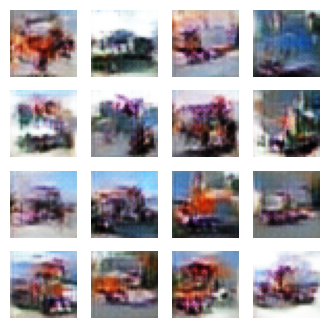

<Figure size 1600x1600 with 0 Axes>

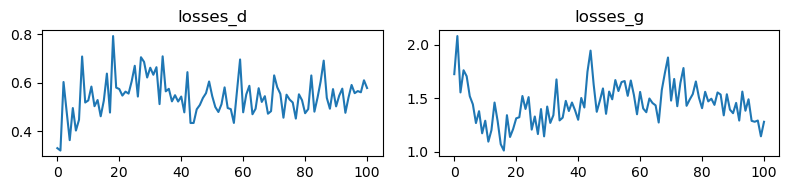

Epoch 101
Time for epoch:  29.109260082244873
Epoch 102
Time for epoch:  35.91414523124695
Epoch 103
Time for epoch:  36.69408178329468
Epoch 104
Time for epoch:  35.92599534988403
Epoch 105
Time for epoch:  36.58774733543396
loss_d=0.60770, loss_g=1.30849
2/2 [==============================] - 0s 7ms/step
	Plotting images and losses


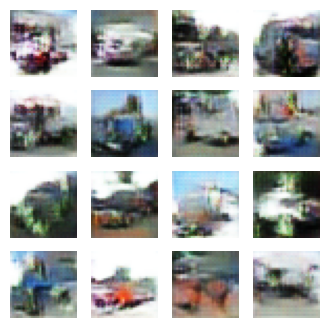

<Figure size 1600x1600 with 0 Axes>

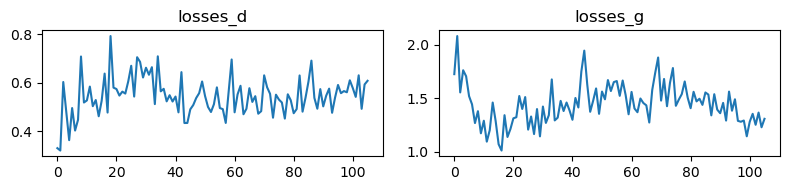

Epoch 106
Time for epoch:  35.47435736656189
Epoch 107
Time for epoch:  35.506043434143066
Epoch 108
Time for epoch:  36.19986701011658
Epoch 109
Time for epoch:  37.31946396827698
Epoch 110
Time for epoch:  36.630619764328
loss_d=0.53919, loss_g=1.18294
2/2 [==============================] - 0s 9ms/step
	Plotting images and losses


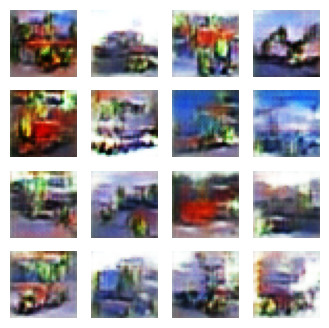

<Figure size 1600x1600 with 0 Axes>

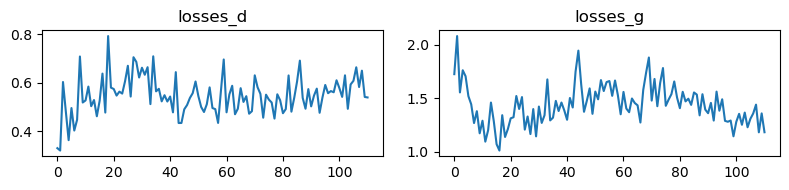

Epoch 111
Time for epoch:  35.76471471786499
Epoch 112
Time for epoch:  36.160491704940796
Epoch 113
Time for epoch:  36.14285087585449
Epoch 114
Time for epoch:  32.65530800819397
Epoch 115
Time for epoch:  26.72189426422119
loss_d=0.53121, loss_g=1.40343
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


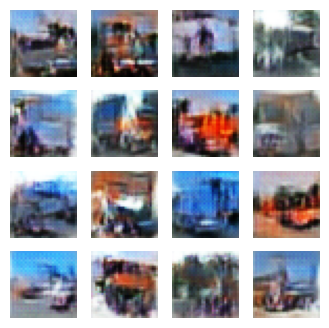

<Figure size 1600x1600 with 0 Axes>

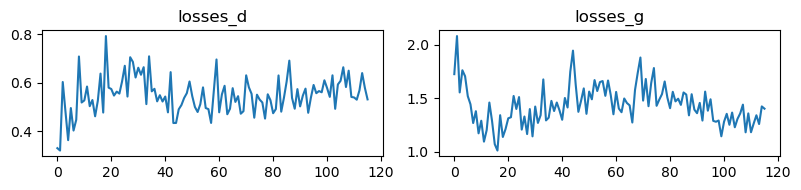

Epoch 116
Time for epoch:  23.42836332321167
Epoch 117
Time for epoch:  24.247010231018066
Epoch 118
Time for epoch:  23.514513731002808
Epoch 119
Time for epoch:  24.232157468795776
Epoch 120
Time for epoch:  24.355284929275513
loss_d=0.56700, loss_g=1.21405
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


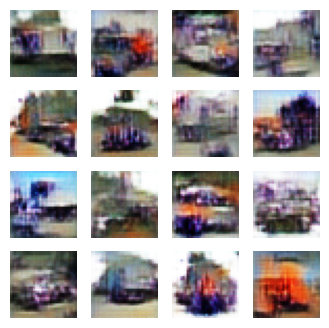

<Figure size 1600x1600 with 0 Axes>

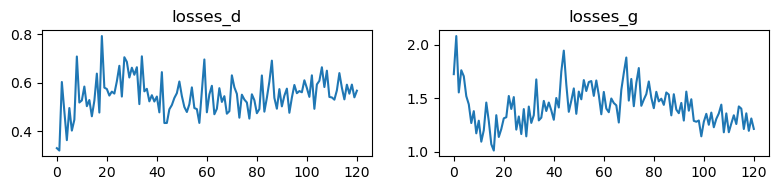

Epoch 121
Time for epoch:  24.936496019363403
Epoch 122
Time for epoch:  24.323314428329468
Epoch 123
Time for epoch:  22.867745876312256
Epoch 124
Time for epoch:  24.264387369155884
Epoch 125
Time for epoch:  23.717079162597656
loss_d=0.57793, loss_g=1.37896
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


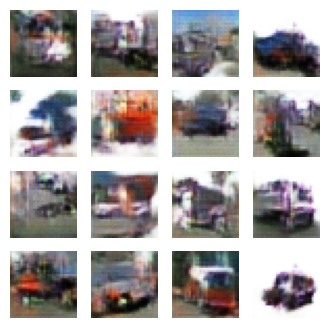

<Figure size 1600x1600 with 0 Axes>

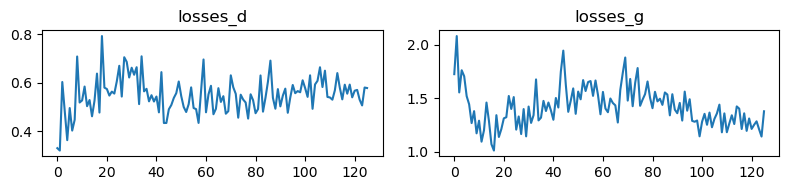

Epoch 126
Time for epoch:  23.79060387611389
Epoch 127
Time for epoch:  22.698678731918335
Epoch 128
Time for epoch:  22.776373386383057
Epoch 129
Time for epoch:  22.703845262527466
Epoch 130
Time for epoch:  22.680279970169067
loss_d=0.48315, loss_g=1.41285
2/2 [==============================] - 0s 3ms/step
	Plotting images and losses


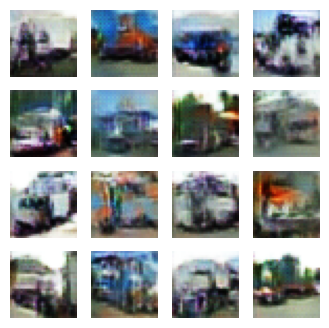

<Figure size 1600x1600 with 0 Axes>

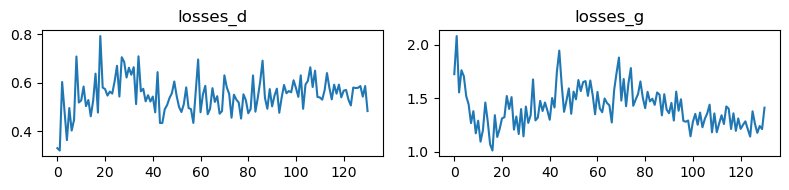

Epoch 131
Time for epoch:  25.736694812774658
Epoch 132
Time for epoch:  25.295119524002075
Epoch 133
Time for epoch:  24.66671872138977
Epoch 134
Time for epoch:  25.859652519226074
Epoch 135
Time for epoch:  25.03156328201294
loss_d=0.53924, loss_g=1.18681
2/2 [==============================] - 0s 4ms/step
	Plotting images and losses


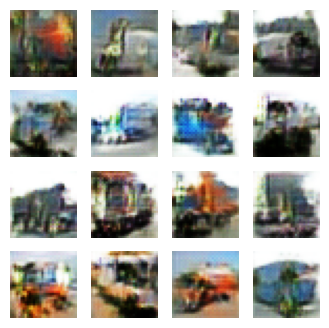

<Figure size 1600x1600 with 0 Axes>

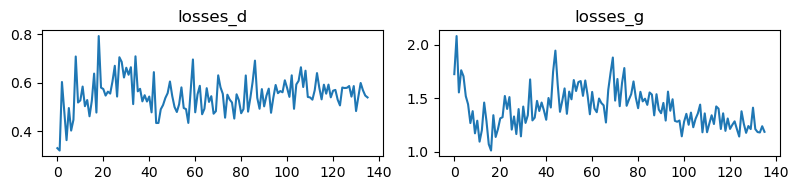

Epoch 136
Time for epoch:  25.482678651809692
Epoch 137
Time for epoch:  24.839619398117065
Epoch 138
Time for epoch:  24.04087209701538
Epoch 139
Time for epoch:  24.967610359191895
Epoch 140
Time for epoch:  26.488431930541992
loss_d=0.54917, loss_g=1.20413
2/2 [==============================] - 0s 6ms/step
	Plotting images and losses


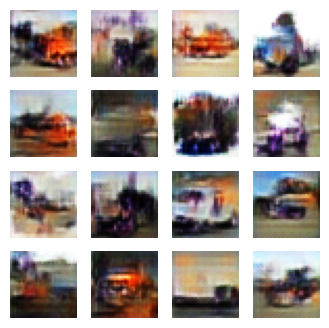

<Figure size 1600x1600 with 0 Axes>

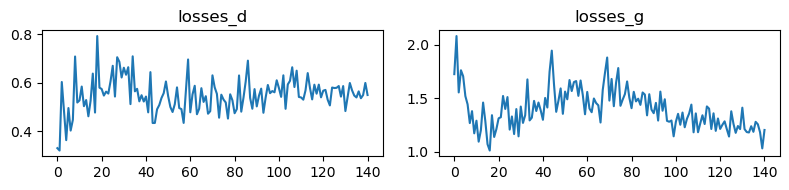

Epoch 141
Time for epoch:  26.554916620254517
Epoch 142
Time for epoch:  26.59122347831726
Epoch 143
Time for epoch:  26.57595443725586
Epoch 144
Time for epoch:  26.710761547088623
Epoch 145
Time for epoch:  26.638557195663452
loss_d=0.56424, loss_g=1.22807
2/2 [==============================] - 0s 5ms/step
	Plotting images and losses


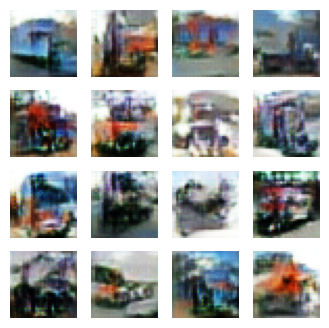

<Figure size 1600x1600 with 0 Axes>

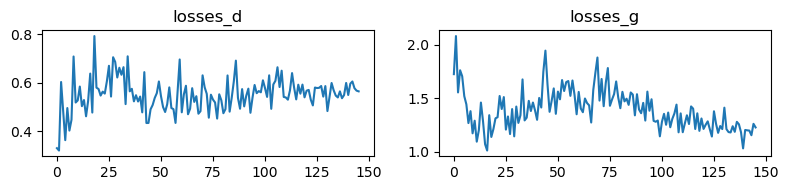

Epoch 146
Time for epoch:  26.56734347343445
Epoch 147
Time for epoch:  26.517847537994385
Epoch 148
Time for epoch:  26.437774896621704
Epoch 149
Time for epoch:  23.975480794906616


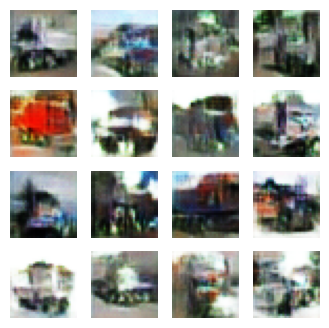

In [5]:
#Training Function
def train(z_dim=100, epochs=150,
          batch_size=16, epoch_per_checkpoint=5, n_checkpoint_images=36):

    #Load the CIFAR10 data
    (X_train, y_train), (X_test, y_test) = cifar10.load_data()
    #Concatenate X_train and X_test for more data
    X_train = np.concatenate((X_train,X_test))
    y_train = np.concatenate((y_train,y_test))
    #Only grab trucks
    index = np.where(y_train.reshape(-1) == 9)
    X_train = X_train[index]
    y_train = y_train[index]
    #Convert data to floats, Scale data to -1, 1
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    X_train = X_train/127.5 - 1.0
    
    
    #Get image shapes and values for reference
    image_shape = X_train[0].shape
    print("image shape {}, min val {}, max val {}".format(image_shape, X_train[0].min(), X_train[0].max()))
    #Plot real images for reference
    plot_images(X_train[:n_checkpoint_images], "real_images.png")


    #Get labels for computing the losses
    labels_real = np.ones(shape=(batch_size, 1)) 
    labels_fake = np.zeros(shape=(batch_size, 1))
    #Smooth labels to prevent mode collapse
    labels_real = smooth_positive_labels(labels_real)
    labels_fake = smooth_negative_labels(labels_fake)

    losses_d, losses_g = [], []

    
    # training loop
    for e in range(epochs):
        start = time.time()
        print("Epoch {}".format(e))
        for i in range(len(X_train) // batch_size):

            # update Discriminator weights
            D.trainable = True

            # Get real samples, train discriminator on them
            real_images = X_train[i*batch_size: (i+1)*batch_size]
            #Feed noisy images to discriminator
#             for j in range(batch_size):
#                 real_images[j] = noisy(real_images[j])
            loss_d_real = D.train_on_batch(x=real_images, y=labels_real)[0]

            # Make fake samples, train discriminator on them
            z = generate_latent_points(z_dim, batch_size)
            fake_images = G.predict_on_batch(z)
            #Feed noisy images to discriminator
#             for j in range(batch_size):
#                 fake_images[j] = noisy(fake_images[j])
            loss_d_fake = D.train_on_batch(x=fake_images, y=labels_fake)[0]

            # Compute Discriminator's loss
            loss_d = 0.5 * (loss_d_real + loss_d_fake)

#             # Train the generator while the discriminator is static
#             D.trainable = False
#             loss_g1 = D_of_G.train_on_batch(x=z, y=labels_real)[0]
#             # Update Generator again (train it twice as much as the Discriminator)
#             loss_g2 = D_of_G.train_on_batch(x=z, y=labels_real)[0]
            
#             # Compute Generator's loss
#             loss_g = 0.5 * (loss_g1 + loss_g2)
            # Train the generator while the discriminator is static
            D.trainable = False
            loss_g = D_of_G.train_on_batch(x=z, y=labels_real)[0]


        #Keep track of losses for plotting
        losses_d.append(loss_d)
        losses_g.append(loss_g)
        
        end = time.time()
        print("Time for epoch:  " + str(end-start))

        
        #Plot losses and generated images every X epochs
        if (e % epoch_per_checkpoint) == 0:
            print("loss_d={:.5f}, loss_g={:.5f}".format(loss_d, loss_g))
            
            # fix a z vector for training evaluation
            z_fixed = generate_latent_points(z_dim, n_checkpoint_images)
            
            fake_images = G.predict(z_fixed)
            print("\tPlotting images and losses")
            plot_images(fake_images, "fake_images_trucks_e{}.png".format(e))
            plot_losses(losses_d, losses_g, "losses.png")
            
            #Show Images
            fake_images = (fake_images + 1) * 127.5
            fake_images = np.rint(fake_images)
            fake_images = fake_images.astype(int)

            fig,axs = plt.subplots(4,4,figsize=(4,4),sharey=True,sharex=True)
            cnt=0
            for k in range(4):
                for l in range(4):
                    axs[k, l].imshow(fake_images[cnt,:,:])
                    axs[k, l].axis('off')
                    cnt+=1

            #Save Model every 10 epochs
#             if (e % 10) == 0 and e != 0:
#                 print('Saving Models')
#                 D.save('./DiscriminatorModel')
#                 D_of_G.save('./CombinedModel')
            
            
train()

4/4 [==============================] - 0s 9ms/step


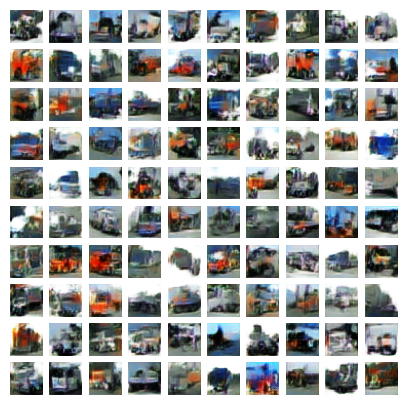

In [6]:
# #Print example images 
n_checkpoint_images = 100
z_dim = 100
#z_fixed = np.random.uniform(-1, 1, size=(n_checkpoint_images, z_dim))
z_fixed = generate_latent_points(z_dim, n_checkpoint_images)
fake_images = G.predict(z_fixed) #Predicted 'images' are (32,32,3) arrays with values -1 to 1
#Convert fake images into actual values for plotting (ints between 0 and 255)
fake_images = (fake_images + 1) * 127.5
fake_images = np.rint(fake_images)
fake_images = fake_images.astype(int)

fig,axs = plt.subplots(10,10,figsize=(5,5),sharey=True,sharex=True)
cnt=0
for k in range(10):
    for l in range(10):
        axs[k, l].imshow(fake_images[cnt,:,:])
        axs[k, l].axis('off')
        cnt+=1

4/4 [==============================] - 0s 9ms/step


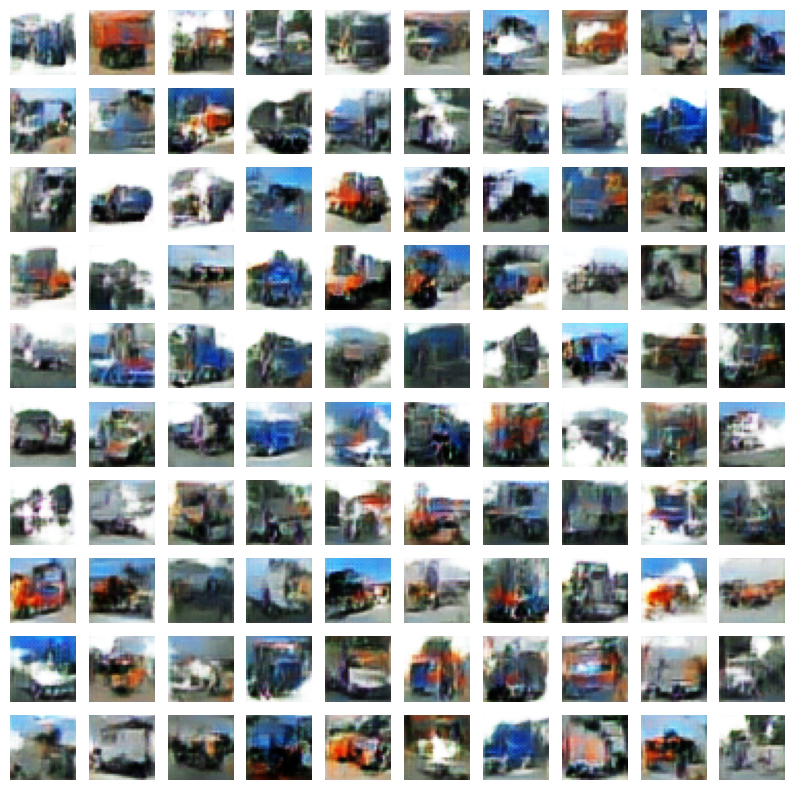

In [7]:
# #Print example images 
#Default Sets, 250 epochs
n_checkpoint_images = 100
z_dim = 100
#z_fixed = np.random.uniform(-1, 1, size=(n_checkpoint_images, z_dim))
z_fixed = generate_latent_points(z_dim, n_checkpoint_images)
fake_images = G.predict(z_fixed) #Predicted 'images' are (32,32,3) arrays with values -1 to 1
#Convert fake images into actual values for plotting (ints between 0 and 255)
fake_images = (fake_images + 1) * 127.5
fake_images = np.rint(fake_images)
fake_images = fake_images.astype(int)

fig,axs = plt.subplots(10,10,figsize=(10,10),sharey=True,sharex=True)
cnt=0
for k in range(10):
    for l in range(10):
        axs[k, l].imshow(fake_images[cnt,:,:])
        axs[k, l].axis('off')
        cnt+=1